Train#=371822 Test#=112548
Labels=[0.0, 1.0]
RF best for 100 trees (d=2 and f=0.5)


<Figure size 600x450 with 0 Axes>

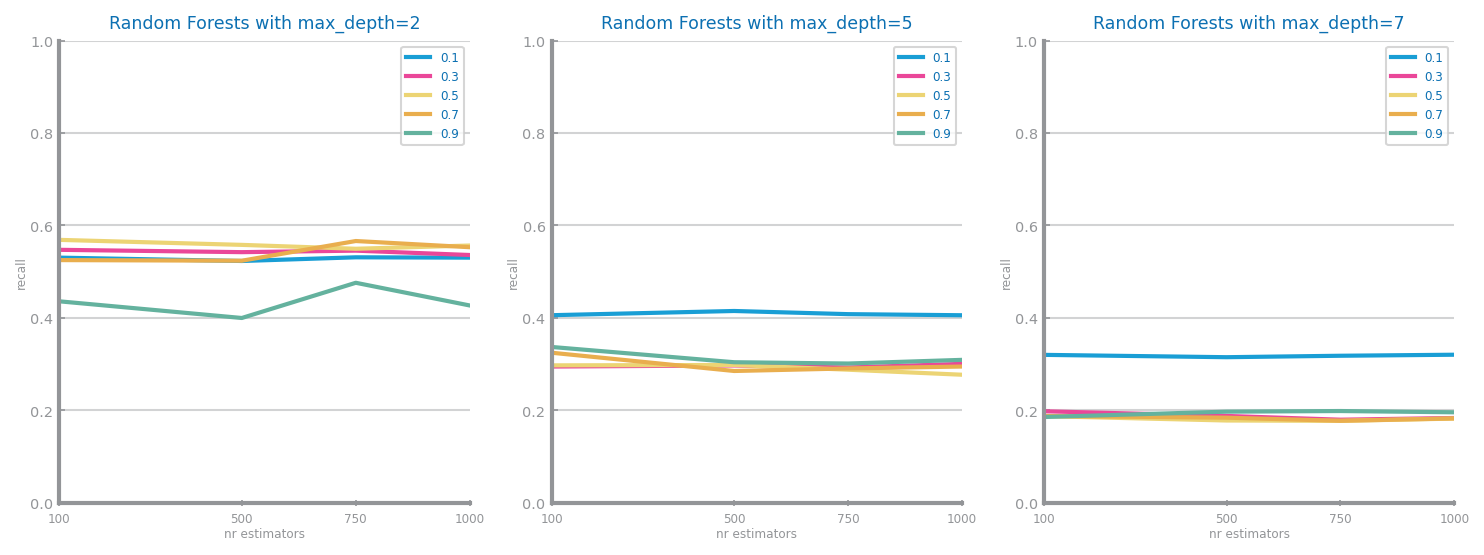

In [1]:
from numpy import array, ndarray
from matplotlib.pyplot import subplots, figure, savefig, show
from sklearn.ensemble import RandomForestClassifier
from dslabs_functions import (
    CLASS_EVAL_METRICS,
    DELTA_IMPROVE,
    read_train_test_from_files,
)
from dslabs_functions import HEIGHT, plot_evaluation_results, plot_multiline_chart


def random_forests_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_trees: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
) -> tuple[RandomForestClassifier | None, dict]:
    n_estimators: list[int] = [100] + [i for i in range(500, nr_max_trees + 1, lag)]
    max_depths: list[int] = [2, 5, 7]
    max_features: list[float] = [0.1, 0.3, 0.5, 0.7, 0.9]

    best_model: RandomForestClassifier | None = None
    best_params: dict = {"name": "RF", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}

    cols: int = len(max_depths)
    _, axs = subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)
    for i in range(len(max_depths)):
        d: int = max_depths[i]
        values = {}
        for f in max_features:
            y_tst_values: list[float] = []
            for n in n_estimators:
                clf = RandomForestClassifier(
                    n_estimators=n, max_depth=d, max_features=f
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (d, f, n)
                    best_model = clf
                # print(f'RF d={d} f={f} n={n}')
            values[f] = y_tst_values
        plot_multiline_chart(
            n_estimators,
            values,
            ax=axs[0, i],
            title=f"Random Forests with max_depth={d}",
            xlabel="nr estimators",
            ylabel=metric,
            percentage=True,
        )
    print(
        f'RF best for {best_params["params"][2]} trees (d={best_params["params"][0]} and f={best_params["params"][1]})'
    )
    return best_model, best_params

file_tag = "class_pos_covid"
train_filename = f"data/{file_tag}_train_smote.csv"
test_filename = f"data/{file_tag}_test.csv"
target = "CovidPos"
eval_metric = "recall"

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(
    train_filename, test_filename, target
)
print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

figure()
best_model, params = random_forests_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_trees=1000,
    lag=250,
    metric=eval_metric,
)
# savefig(f"images/{file_tag}_rf_{eval_metric}_study.png")
# show()

array([<Axes: >,
       <Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>],
      dtype=object)

<Figure size 600x450 with 0 Axes>

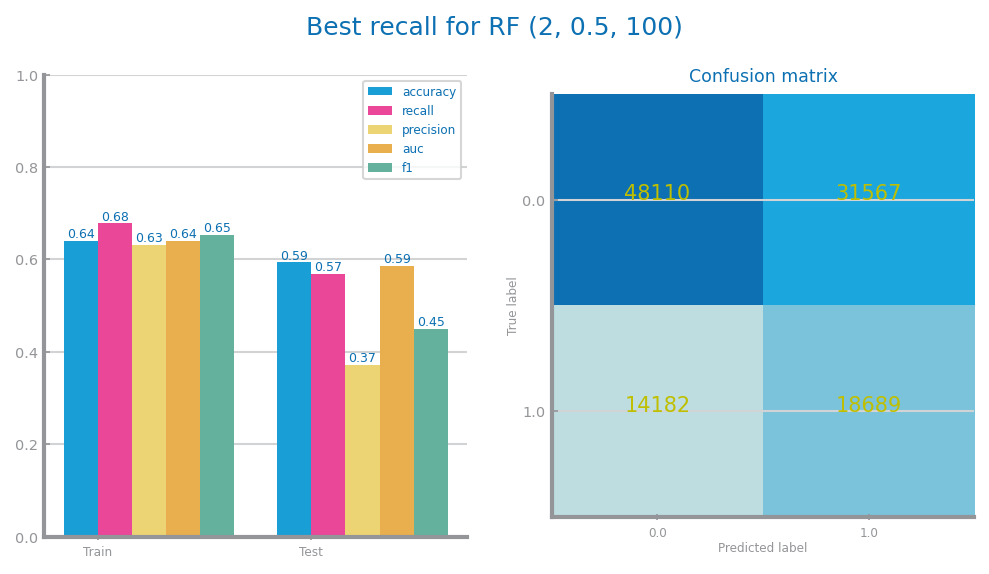

In [2]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
# savefig(f'images/{file_tag}_rf_{params["name"]}_best_{params["metric"]}_eval.png')
# show()

1. AgeCategory (0.3530055474129617)
2. PneumoVaxEver (0.14887343843735762)
3. FluVaxLast12 (0.13993159229230134)
4. HIVTesting (0.11084467168930173)
5. AlcoholDrinkers (0.10510688586431077)
6. ChestScan (0.06711000451043664)
7. TetanusLast10Tdap (0.038487024301268706)
8. SmokerStatus (0.010676184851737451)
9. SleepHours (0.010617027130533686)
10. LastCheckupTime (0.00476778016103766)
11. RemovedTeeth (0.004438791140113586)
12. HadArthritis (0.00249780745456353)
13. PhysicalActivities (0.002298083268392346)
14. HadAsthma (0.001345161485683339)
15. HadDiabetes (0.0)
16. ECigaretteUsage (0.0)
17. HadHeartAttack (0.0)
18. BMI (0.0)
19. MentalHealthDays (0.0)
20. PhysicalHealthDays (0.0)
21. HighRiskLastYear (0.0)
22. HadAngina (0.0)
23. HadStroke (0.0)
24. HadSkinCancer (0.0)
25. HadCOPD (0.0)
26. HadDepressiveDisorder (0.0)
27. HadKidneyDisease (0.0)
28. DeafOrHardOfHearing (0.0)
29. BlindOrVisionDifficulty (0.0)
30. DifficultyConcentrating (0.0)
31. DifficultyWalking (0.0)
32. Difficulty

<Axes: title={'center': 'RF variables importance'}, xlabel='importance', ylabel='variables'>

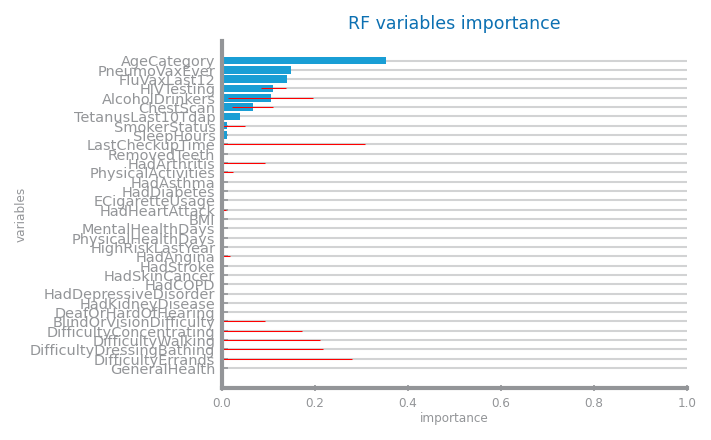

In [3]:
from numpy import std, argsort
from dslabs_functions import plot_horizontal_bar_chart

stdevs: list[float] = list(
    std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)
)
importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title="RF variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
# savefig(f"images/{file_tag}_rf_{eval_metric}_vars_ranking.png")

<Axes: title={'center': 'RF overfitting study for d=2 and f=0.5'}, xlabel='nr_estimators', ylabel='recall'>

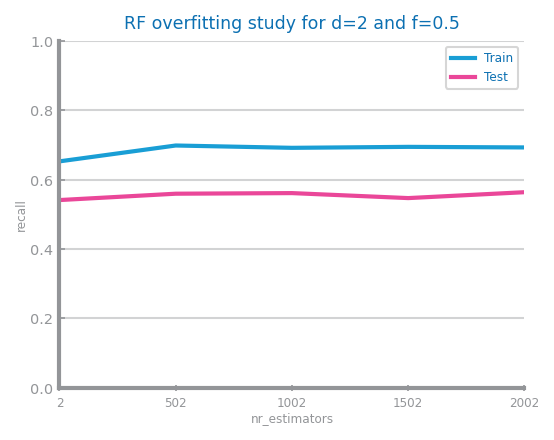

In [4]:
d_max: int = params["params"][0]
feat: float = params["params"][1]
nr_estimators: list[int] = [i for i in range(2, 2501, 500)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric: str = "recall"

for n in nr_estimators:
    clf = RandomForestClassifier(n_estimators=n, max_depth=d_max, max_features=feat)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"RF overfitting study for d={d_max} and f={feat}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
# savefig(f"images/{file_tag}_rf_{eval_metric}_overfitting.png")

[Text(0.5, 0.8333333333333334, 'AgeCategory <= 59.95\nsamples = 234941\nvalue = [185701, 186121]\nclass = 1.0'),
 Text(0.25, 0.5, 'HIVTesting <= 0.0\nsamples = 134072\nvalue = [89564, 122716]\nclass = 1.0'),
 Text(0.125, 0.16666666666666666, 'samples = 67671\nvalue = [52094, 55000]\nclass = 1.0'),
 Text(0.375, 0.16666666666666666, 'samples = 66401\nvalue = [37470, 67716]\nclass = 1.0'),
 Text(0.75, 0.5, 'ChestScan <= 0.0\nsamples = 100869\nvalue = [96137, 63405]\nclass = 0.0'),
 Text(0.625, 0.16666666666666666, 'samples = 42578\nvalue = [46386, 21122]\nclass = 0.0'),
 Text(0.875, 0.16666666666666666, 'samples = 58291\nvalue = [49751, 42283]\nclass = 0.0')]

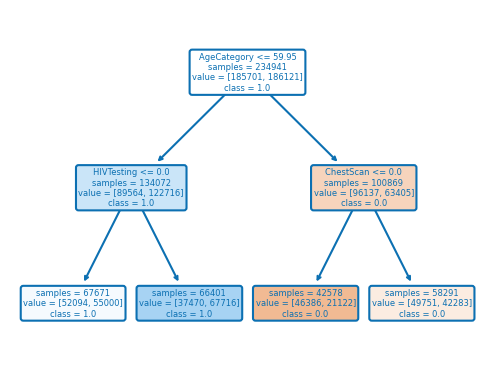

In [7]:

from sklearn.tree import plot_tree
max_depth2show: int = 3
st_labels: list[str] = [str(value) for value in labels]

figure()
plot_tree(
    best_model.estimators_[0],
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    precision=2,
)